# Fraud Detection Analysis and Modeling 
---


## 1. Setup & Imports
##### We begin by importing all the necessary libraries for data manipulation, visualization, feature engineering, and modeling.

In [54]:
import pandas as pd
import numpy as np
import json
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score,make_scorer, f1_score, roc_curve, precision_recall_curve, auc, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, f1_score
import xgboost as xgb
import catboost as cb
import time
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix,
                             roc_auc_score, roc_curve, precision_recall_curve, auc)
import matplotlib.pyplot as plt
import seaborn as sns

## 2. Loading & EDA

In [ ]:
def load_data(file_path: str) -> pd.DataFrame:
    # Function to load data from a JSON file
    print(f"Attempting to load data from: {file_path}")
    try:
        df = pd.read_json(file_path, lines=True)
        pd.set_option('display.float_format', '{:.2f}'.format)
        print("Data loaded successfully.")
        return df
    except FileNotFoundError:
        print(f"Error: The file was not found at the specified path.")
        return pd.DataFrame() # Return an empty DataFrame on error

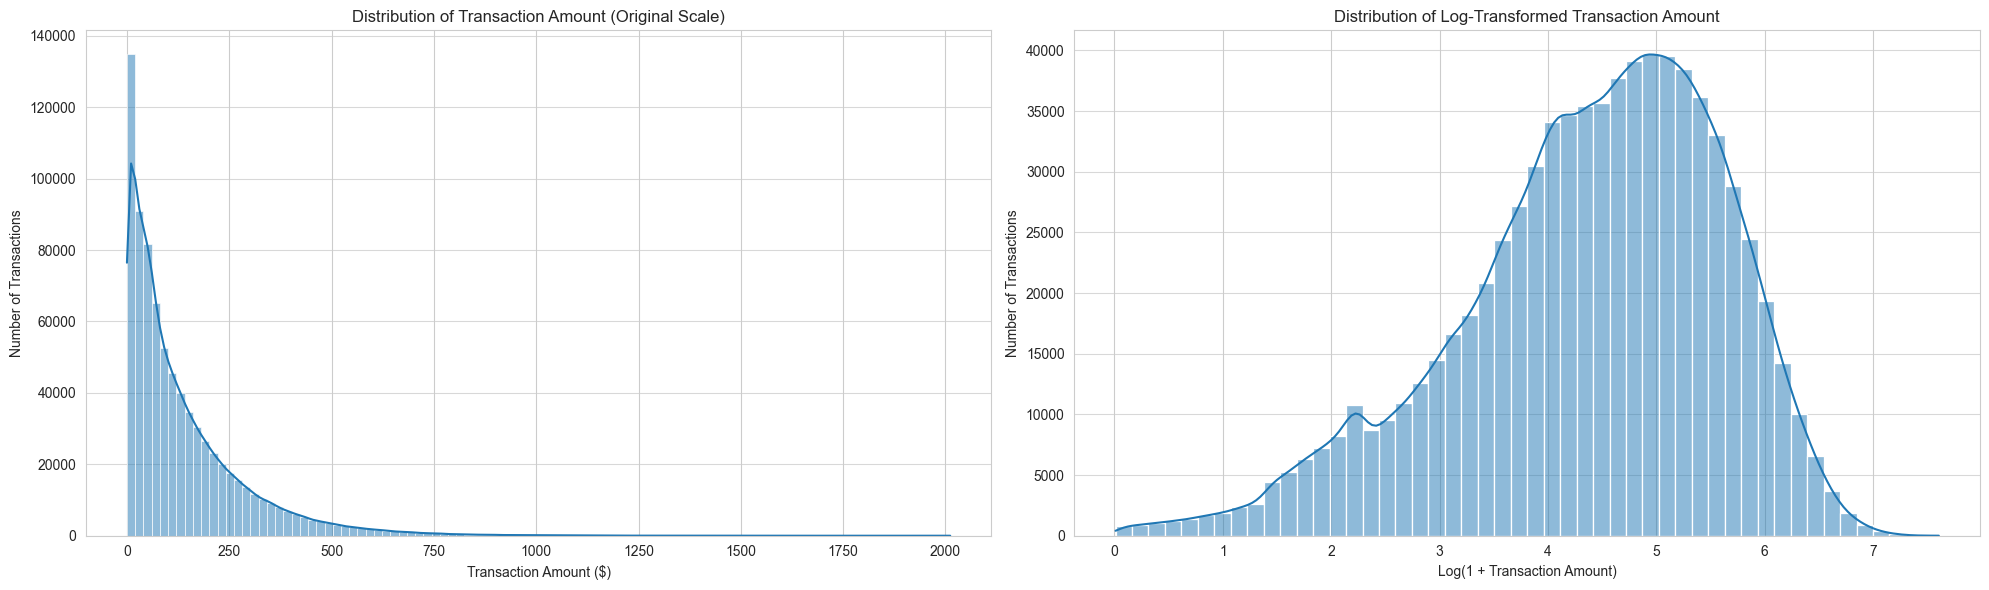

In [19]:
# Create subplots for side-by-side comparison
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

# Plot 1: Original Distribution
sns.histplot(df['transactionAmount'], bins=100, kde=True, ax=axes[0])
axes[0].set_title('Distribution of Transaction Amount (Original Scale)')
axes[0].set_xlabel('Transaction Amount ($)')
axes[0].set_ylabel('Number of Transactions')
axes[0].grid(axis='y', alpha=0.75)

# Plot 2: Log-Transformed Distribution
# We use log1p which calculates log(1+x) to handle potential zero values gracefully
df_positive_amounts = df[df['transactionAmount'] > 0]['transactionAmount']
sns.histplot(np.log1p(df_positive_amounts), bins=50, kde=True, ax=axes[1])
axes[1].set_title('Distribution of Log-Transformed Transaction Amount')
axes[1].set_xlabel('Log(1 + Transaction Amount)')
axes[1].set_ylabel('Number of Transactions')
axes[1].grid(axis='y', alpha=0.75)

plt.tight_layout()
plt.show()

#### Normalizing the Transaction Amount
To handle the severe right-skew of the transactionAmount feature, we apply a log transformation. The side-by-side comparison below shows how this simple step effectively normalizes the distribution, This suggests spending reflects frequent small purchases and infrequent large ones, highlighting the need for data transformation in ML.

Attempting to load data from: transactions.txt
Data loaded successfully.
Fraud Distribution:
isFraud
False    773946
True      12417
Name: count, dtype: int64

Fraud Percentage:
isFraud
False   98.42
True     1.58
Name: proportion, dtype: float64


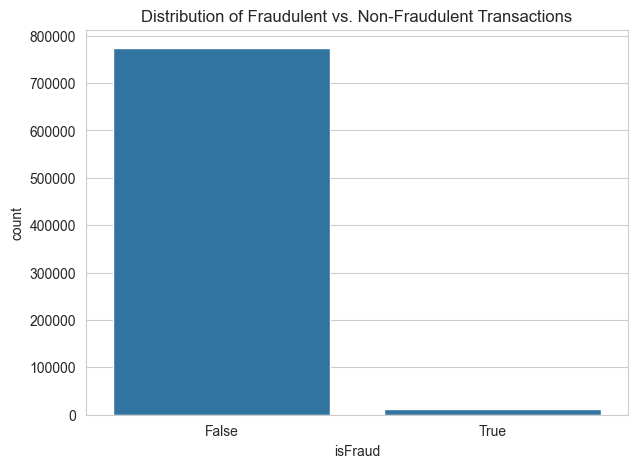

In [14]:
# Load the data into df if not already loaded
df = load_data('transactions.txt')

# 1. Calculate the distribution of the target variable
print("Fraud Distribution:")
print(df['isFraud'].value_counts())

# 2. Calculate the percentage distribution
print("\nFraud Percentage:")
print(df['isFraud'].value_counts(normalize=True) * 100)

# 3. Visualize the distribution
plt.figure(figsize=(7, 5))
sns.countplot(x='isFraud', data=df)
plt.title('Distribution of Fraudulent vs. Non-Fraudulent Transactions')
plt.show()

Summary Statistics for Numerical Features:
       creditLimit  availableMoney  transactionAmount  currentBalance
count    786363.00       786363.00          786363.00       786363.00
mean      10759.46         6250.73             136.99         4508.74
std       11636.17         8880.78             147.73         6457.44
min         250.00        -1005.63               0.00            0.00
25%        5000.00         1077.42              33.65          689.91
50%        7500.00         3184.86              87.90         2451.76
75%       15000.00         7500.00             191.48         5291.10
max       50000.00        50000.00            2011.54        47498.81


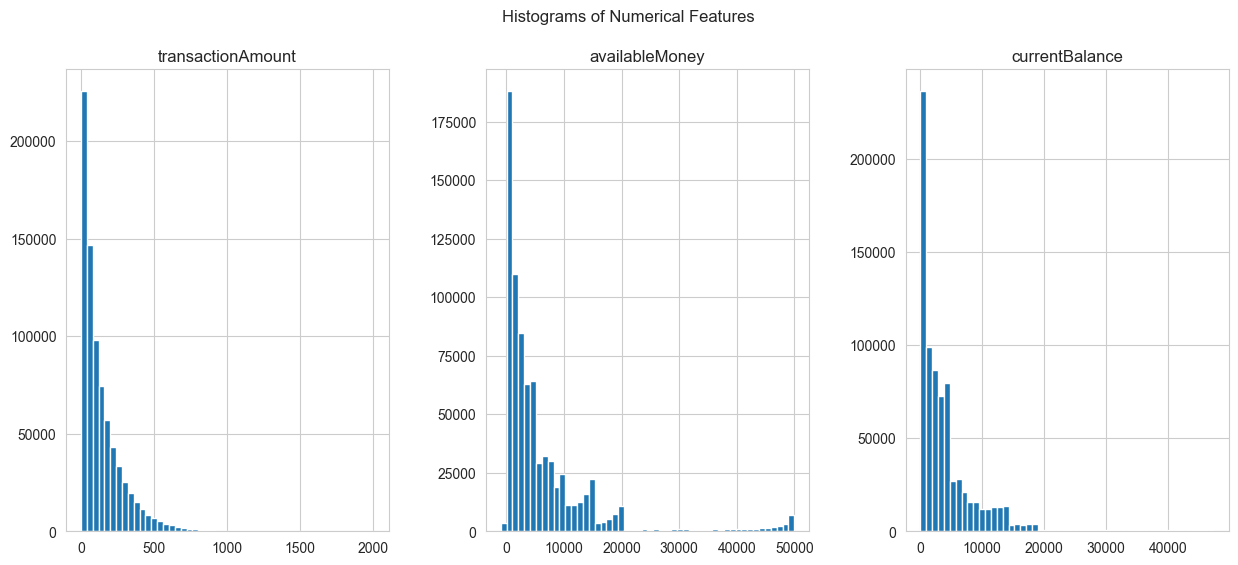

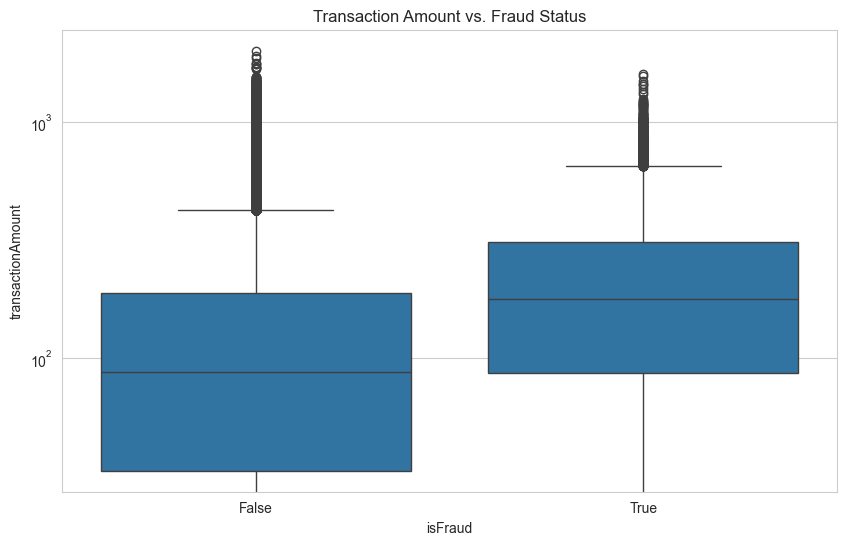

In [ ]:
# 1. Get summary statistics
print("Summary Statistics for Numerical Features:")
print(df[['creditLimit', 'availableMoney', 'transactionAmount', 'currentBalance']].describe())

# 2. Visualize distributions with histograms
df[['transactionAmount', 'availableMoney', 'currentBalance']].hist(bins=50, figsize=(15, 6), layout=(1, 3))
plt.suptitle('Histograms of Numerical Features')
plt.show()

# 3. Compare transactionAmount for fraudulent vs. non-fraudulent transactions
plt.figure(figsize=(10, 6))
sns.boxplot(x='isFraud', y='transactionAmount', data=df)
plt.title('Transaction Amount vs. Fraud Status')
plt.yscale('log') 
plt.show()

C:\Users\hmank\AppData\Local\Temp\ipykernel_17136\248021746.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col])


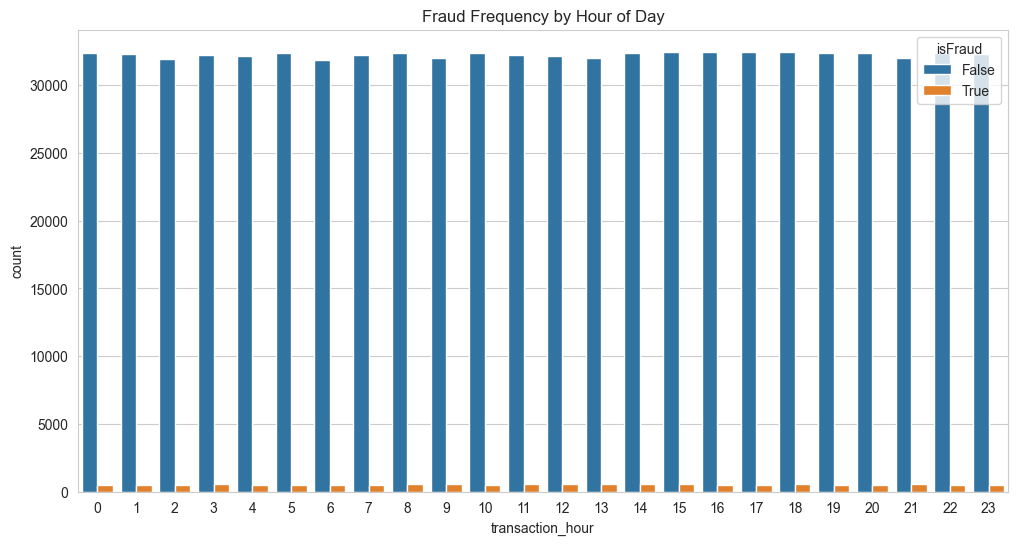

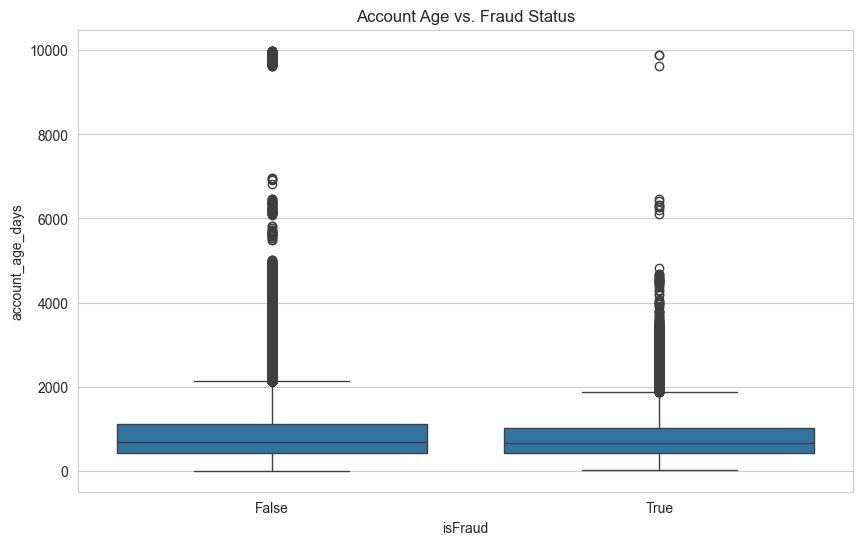

In [16]:
# 1. Convert date columns from object to datetime
for col in ['transactionDateTime', 'accountOpenDate', 'currentExpDate', 'dateOfLastAddressChange']:
    df[col] = pd.to_datetime(df[col])

# 2. Extract features from transactionDateTime
df['transaction_hour'] = df['transactionDateTime'].dt.hour
df['transaction_day_of_week'] = df['transactionDateTime'].dt.day_name()

# 3. Analyze fraud by hour of the day
plt.figure(figsize=(12, 6))
sns.countplot(x='transaction_hour', data=df, hue='isFraud')
plt.title('Fraud Frequency by Hour of Day')
plt.show()

# 4. Create a new feature: Account Age at time of transaction
df['account_age_days'] = (df['transactionDateTime'] - df['accountOpenDate']).dt.days

# 5. Plot account age vs. fraud
plt.figure(figsize=(10, 6))
sns.boxplot(x='isFraud', y='account_age_days', data=df)
plt.title('Account Age vs. Fraud Status')
plt.show()

Top 10 Merchant Categories:
merchantCategoryCode
online_retail    202156
fastfood         112138
entertainment     80098
food              75490
online_gifts      66238
rideshare         51136
hotels            34097
fuel              23910
subscriptions     22901
auto              21651
Name: count, dtype: int64


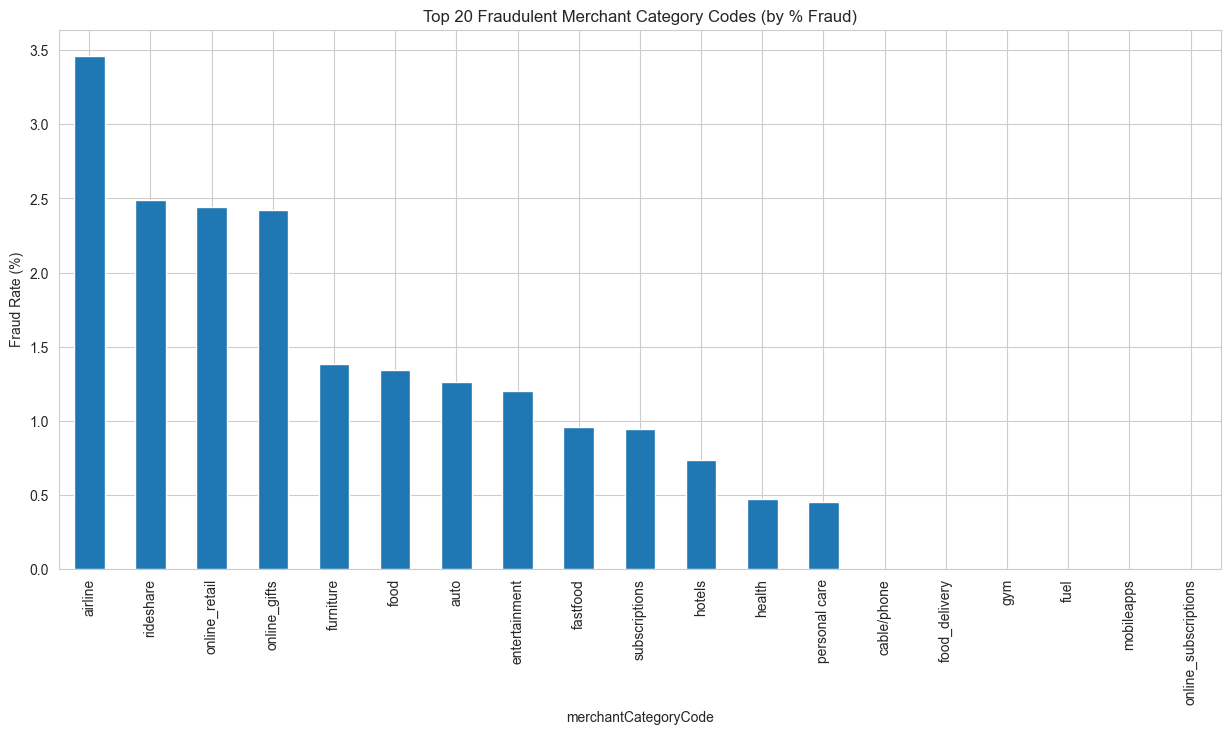

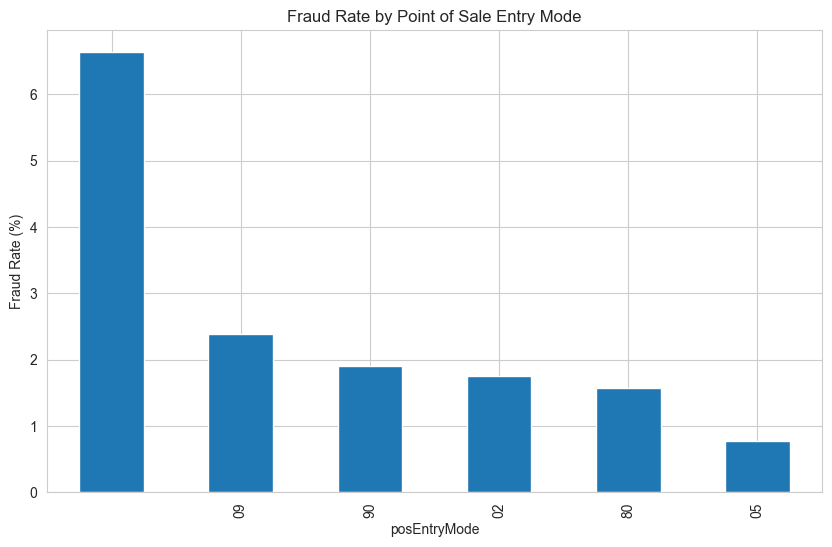

In [ ]:
# 1. Analyze a key categorical feature like 'merchantCategoryCode'
print("Top 10 Merchant Categories:")
print(df['merchantCategoryCode'].value_counts().head(10))

# 2. Visualize fraud rate by category
fraud_rate_by_mcc = df.groupby('merchantCategoryCode')['isFraud'].mean().sort_values(ascending=False) * 100

plt.figure(figsize=(15, 7))
fraud_rate_by_mcc.head(20).plot(kind='bar') # Plot top 20 riskiest categories
plt.title('Top 20 Fraudulent Merchant Category Codes (by % Fraud)')
plt.ylabel('Fraud Rate (%)')
plt.show()

# 3.'posEntryMode'
fraud_rate_by_pos = df.groupby('posEntryMode')['isFraud'].mean().sort_values(ascending=False) * 100

plt.figure(figsize=(10, 6))
fraud_rate_by_pos.plot(kind='bar')
plt.title('Fraud Rate by Point of Sale Entry Mode')
plt.ylabel('Fraud Rate (%)')
plt.show()

Number of unique customers: 5000
Number of unique merchants: 2490


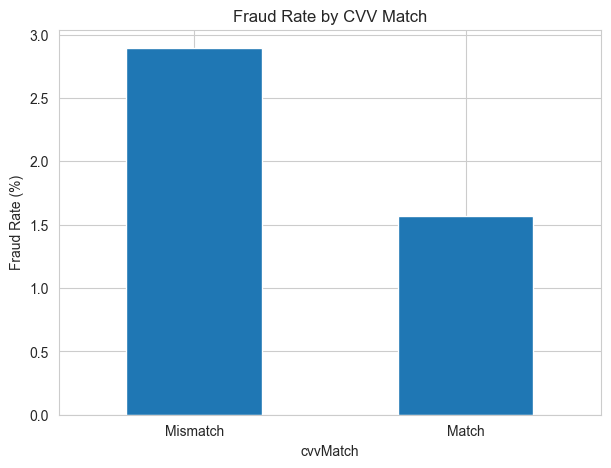

In [ ]:
# 1. Check the number of unique values (cardinality)
print("Number of unique customers:", df['customerId'].nunique())
print("Number of unique merchants:", df['merchantName'].nunique())

# 2. Engineer a new feature: Did the entered CVV match the card's CVV?
df['cvvMatch'] = (df['cardCVV'] == df['enteredCVV'])

# 3. Analyze fraud rate based on this new feature
fraud_rate_by_cvv = df.groupby('cvvMatch')['isFraud'].mean() * 100

plt.figure(figsize=(7, 5))
fraud_rate_by_cvv.plot(kind='bar')
plt.title('Fraud Rate by CVV Match')
plt.ylabel('Fraud Rate (%)')
plt.xticks(ticks=[0, 1], labels=['Mismatch', 'Match'], rotation=0)
plt.show()

# Hypotheses
* Value and Velocity of Transactions: Fraudulent transactions are expected to deviate from normal spending patterns. my hypotheses is that fraudulent transactions will, on average, involve significantly higher monetary amounts to maximize the illicit gain before detection.

- Context of High-Risk Transactions: Specific merchant categories (e.g., online retail, travel) and transaction types carry a higher risk of fraud.

* Exploitation of Verification Measures: A mismatch between the entered CVV and the card's actual CVV is a strong predictor of fraud.

* Targeting of Accounts: The age of an account (time since opening) is a significant factor in its overall fraud risk.

* Data Imbalance: The dataset is highly imbalanced, with fraudulent transactions being rare events requiring special handling.

# Feature Engineering

In [20]:
class FraudFeatureEngineer:
# A class to encapsulate feature engineering steps for fraud detection
    def __init__(self):
        self.initial_cols_to_drop = [
            'echoBuffer', 'posOnPremises', 'recurringAuthInd', 'merchantCity',
            'merchantState', 'merchantZip', 'cardCVV', 'enteredCVV', 'cardLast4Digits'
        ]
        self.categorical_cols_to_encode = [
            'acqCountry', 'merchantCountryCode', 'posEntryMode',
            'posConditionCode', 'merchantCategoryCode', 'transactionType'
        ]
        print("FeatureEngineer initialized. Ready to transform data.")

    def _clean_and_convert_types(self, df: pd.DataFrame) -> pd.DataFrame:
        df.drop_duplicates(inplace=True)
        df.drop(columns=self.initial_cols_to_drop, errors='ignore', inplace=True)
        for col in ['transactionDateTime', 'accountOpenDate', 'dateOfLastAddressChange']:
            df[col] = pd.to_datetime(df[col], errors='coerce')
        df['currentExpDate'] = pd.to_datetime(df['currentExpDate'], format='%m/%Y', errors='coerce')
        return df

    def _create_lag_features(self, df: pd.DataFrame) -> pd.DataFrame:
        df = df.sort_values(by=['accountNumber', 'transactionDateTime']).reset_index(drop=True)
        group_cols = ['accountNumber', 'merchantName']
        
        # Reversal logic
        df['prev_transactionType_rev'] = df.groupby(group_cols)['transactionType'].shift(1)
        df['prev_transactionAmount_rev'] = df.groupby(group_cols)['transactionAmount'].shift(1)
        df['prev_transactionDateTime_rev'] = df.groupby(group_cols)['transactionDateTime'].shift(1)
        reversal_conditions = ((df['transactionType'] == 'REVERSAL') & (df['prev_transactionType_rev'] == 'PURCHASE') & (np.isclose(df['transactionAmount'], df['prev_transactionAmount_rev'], atol=0.01)) & (df['transactionDateTime'] - df['prev_transactionDateTime_rev']).dt.total_seconds().between(1, 24 * 3600))
        reversal_indices = df[reversal_conditions].index
        purchase_indices_rev = reversal_indices[reversal_indices > 0] - 1
        df['is_reversal_pair'] = False
        df.loc[reversal_indices, 'is_reversal_pair'] = True
        df.loc[purchase_indices_rev, 'is_reversal_pair'] = True

        # Multi-swipe logic
        purchases = df['transactionType'] == 'PURCHASE'
        df['prev_transactionAmount_ms'] = df.loc[purchases].groupby(group_cols)['transactionAmount'].shift(1)
        df['prev_transactionDateTime_ms'] = df.loc[purchases].groupby(group_cols)['transactionDateTime'].shift(1)
        multiswipe_conditions = ((df['transactionType'] == 'PURCHASE') & (df['transactionAmount'] == df['prev_transactionAmount_ms']) & (df['transactionDateTime'] - df['prev_transactionDateTime_ms']).dt.total_seconds().between(1, 300))
        multiswipe_indices = df[multiswipe_conditions].index
        purchase_indices_ms = multiswipe_indices[multiswipe_indices > 0] - 1
        df['is_multi_swipe'] = False
        df.loc[multiswipe_indices, 'is_multi_swipe'] = True
        df.loc[purchase_indices_ms, 'is_multi_swipe'] = True

        df.drop(columns=['prev_transactionType_rev', 'prev_transactionAmount_rev', 'prev_transactionDateTime_rev', 'prev_transactionAmount_ms', 'prev_transactionDateTime_ms'], inplace=True, errors='ignore')
        return df
    # Domain-specific features
    def _create_domain_features(self, df: pd.DataFrame) -> pd.DataFrame:
        df['transaction_hour'] = df['transactionDateTime'].dt.hour
        df['transaction_day_of_week'] = df['transactionDateTime'].dt.dayofweek
        df['is_weekend'] = df['transaction_day_of_week'].isin([5, 6])
        df['account_age_days'] = (df['transactionDateTime'] - df['accountOpenDate']).dt.days
        df['days_to_expiration'] = (df['currentExpDate'] - df['transactionDateTime']).dt.days
        df['transactionAmount_log1p'] = np.log1p(df['transactionAmount'])
        df['is_zero_amount'] = df['transactionAmount'] == 0
        epsilon = 1e-6
        df['available_money_ratio'] = df['availableMoney'] / (df['creditLimit'] + epsilon)
        df['balance_to_limit_ratio'] = df['currentBalance'] / (df['creditLimit'] + epsilon)
        return df

    def transform(self, df: pd.DataFrame) -> pd.DataFrame:
    # Main method to run the full feature engineering pipeline
        print("Starting feature engineering pipeline...")
        df_transformed = df.copy()
        
        print("--> Step A: Cleaning data and converting types...")
        df_transformed = self._clean_and_convert_types(df_transformed)
        
        print("--> Step B: Creating lag-based features (reversals, multi-swipes)...")
        df_transformed = self._create_lag_features(df_transformed)
        
        print("--> Step C: Creating domain-specific time and financial features...")
        df_transformed = self._create_domain_features(df_transformed)
        
        print("--> Step D: Applying one-hot encoding...")
        df_transformed = pd.get_dummies(df_transformed, columns=self.categorical_cols_to_encode, prefix=self.categorical_cols_to_encode, drop_first=True)

        print("Feature engineering pipeline complete.")
        return df_transformed

### Final Data Preprocessing
* We now finalize our data splits for modeling with three key steps, all designed to prevent data leakage:

* Target Encoding: High-cardinality features (e.g., accountNumber) are converted to numerical values, with encoding rules learned strictly from the training set.

* Feature Scaling: All numerical features are scaled using the outlier-resistant RobustScaler.

* Data Balancing: The training set only is balanced using SMOTE to correct for the severe class imbalance, ensuring our evaluation remains realistic.

# Applying Feature Engineering

In [29]:
engineer = FraudFeatureEngineer()
df_featured = engineer.transform(df)

# TIME-BASED TRAIN-VALIDATION-TEST SPLIT
print("\n Splitting Data into Time-Based Sets")
# Sort by datetime to ensure chronological order
df_featured = df_featured.sort_values(by='transactionDateTime').reset_index(drop=True)

# Define split points
total_rows = len(df_featured)
train_end_idx = int(total_rows * 0.70)
val_end_idx = int(total_rows * 0.85)

# Create the splits
train_df = df_featured.iloc[:train_end_idx].copy()
val_df = df_featured.iloc[train_end_idx:val_end_idx].copy()
test_df = df_featured.iloc[val_end_idx:].copy()

print(f"Training set size:   {len(train_df)} rows")
print(f"Validation set size: {len(val_df)} rows")
print(f"Test set size:       {len(test_df)} rows")

FeatureEngineer initialized. Ready to transform data.
Starting feature engineering pipeline...
--> Step A: Cleaning data and converting types...
--> Step B: Creating lag-based features (reversals, multi-swipes)...
--> Step C: Creating domain-specific time and financial features...
--> Step D: Applying one-hot encoding...
Feature engineering pipeline complete.

 Splitting Data into Time-Based Sets
Training set size:   550454 rows
Validation set size: 117954 rows
Test set size:       117955 rows


# Target Encoding to avoid Data Leakage

* First, we convert high-cardinality features like accountNumber into numerical values using Target Encoding, learning the rules only from the training set to prevent data leakage.

* Next, all numerical features are scaled using RobustScaler, which is highly effective against the outliers commonly found in financial data.

* Finally, we balance our training set using SMOTE to address the severe class imbalance, ensuring the model can effectively learn to identify the rare fraud cases.

In [30]:
#  TARGET ENCODING HIGH-CARDINALITY FEATURES 
print("\n Applying Target Encoding")
high_cardinality_cols = ['accountNumber', 'merchantName', 'customerId']
target = 'isFraud'

for col in high_cardinality_cols:
    target_mean_map = train_df.groupby(col)[target].mean()
    train_df[f'{col}_encoded'] = train_df[col].map(target_mean_map)
    val_df[f'{col}_encoded'] = val_df[col].map(target_mean_map)
    test_df[f'{col}_encoded'] = test_df[col].map(target_mean_map)
    global_mean = train_df[target].mean()
    train_df[f'{col}_encoded'].fillna(global_mean, inplace=True)
    val_df[f'{col}_encoded'].fillna(global_mean, inplace=True)
    test_df[f'{col}_encoded'].fillna(global_mean, inplace=True)

#  PREPARE FINAL FEATURE SETS AND SCALE
print("\n--- Preparing Final Datasets and Scaling Features ---")
cols_to_drop_final = high_cardinality_cols + ['transactionDateTime', 'currentExpDate', 'accountOpenDate', 'dateOfLastAddressChange']
train_df.drop(columns=cols_to_drop_final, inplace=True, errors='ignore')
val_df.drop(columns=cols_to_drop_final, inplace=True, errors='ignore')
test_df.drop(columns=cols_to_drop_final, inplace=True, errors='ignore')

features = [col for col in train_df.columns if col != target]
X_train, y_train = train_df[features], train_df[target]
X_val, y_val = val_df[features], val_df[target]
X_test, y_test = test_df[features], test_df[target]

scaler = RobustScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=features)
X_val_scaled = pd.DataFrame(scaler.transform(X_val), columns=features)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=features)

# HANDLE CLASS IMBALANCE WITH SMOTE 
print("\n Handling Class Imbalance with SMOTE ")
print(f"Original training distribution: {Counter(y_train)}")
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)
print(f"Resampled training distribution: {Counter(y_train_resampled)}")


 Applying Target Encoding


C:\Users\hmank\AppData\Local\Temp\ipykernel_17136\693984960.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df[f'{col}_encoded'].fillna(global_mean, inplace=True)
C:\Users\hmank\AppData\Local\Temp\ipykernel_17136\693984960.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a co


--- Preparing Final Datasets and Scaling Features ---

 Handling Class Imbalance with SMOTE 
Original training distribution: Counter({False: 541541, True: 8913})
Resampled training distribution: Counter({False: 541541, True: 541541})


# Select Best Features

* To improve model performance and reduce complexity, we will perform feature selection to isolate the most predictive signals. We will use mutual information to identify the top 40 features that share the strongest relationship with the target.

In [31]:
print("\n Selecting Top Features with Mutual Information")
k_features = 40 
selector = SelectKBest(mutual_info_classif, k=k_features)
selector.fit(X_train_resampled, y_train_resampled)
selected_feature_names = X_train_resampled.columns[selector.get_support()]

print(f"Top {len(selected_feature_names)} features selected.")

# Filter all datasets to keep only these top features
X_train_final = X_train_resampled[selected_feature_names]
X_val_final = X_val_scaled[selected_feature_names]
X_test_final = X_test_scaled[selected_feature_names]

print(f"Final shape of training data for model: {X_train_final.shape}")


 Selecting Top Features with Mutual Information
Top 40 features selected.
Final shape of training data for model: (1083082, 40)


# Training

### Comparative Model Training
With our data fully prepared, we now proceed to the model training phase. Our strategy is designed to rigorously compare different models to find the most effective one for this task.

* _Establishing a Baseline_: We begin by training a simple Logistic Regression model. This provides a crucial performance baseline against which we can measure more complex models.

* _Training Advanced Models_: To capture the complex, non-linear patterns typical of fraud data, we then train two state-of-the-art gradient boosting models: XGBoost and CatBoost.

* _Hyperparameter Optimization_: To unlock the full potential of these advanced models, we use RandomizedSearchCV to systematically search for the optimal combination of hyperparameters for each.

* _Structured and Repeatable Code_: The entire training and tuning process is encapsulated in functions. This ensures our code is clean, readable, and produces a final dictionary of trained models ready for a head-to-head evaluation.

In [40]:
def train_logistic_regression(X_train, y_train):
    # Function to train a baseline Logistic Regression model
    print("--- Training Baseline Model: Logistic Regression ---")
    model = LogisticRegression(random_state=42, solver='liblinear', max_iter=1000)
    model.fit(X_train, y_train)
    print("Logistic Regression training complete.\n")
    return model

In [41]:
def tune_and_train_model(model_name: str, base_model, param_grid: dict, X_train, y_train, n_iter: int):
   # Function to perform hyperparameter tuning and training for advanced models
    print(f"--- Tuning and Training Advanced Model: {model_name} ---")
    

    if 'scale_pos_weight' in base_model.get_params():
        print("Note: Setting 'scale_pos_weight' to 1 because the training data is already balanced by SMOTE.")
        base_model.set_params(scale_pos_weight=1)

    f1_scorer = make_scorer(f1_score, average='binary')

    random_search = RandomizedSearchCV(
        estimator=base_model,
        param_distributions=param_grid,
        n_iter=n_iter,
        scoring=f1_scorer,
        n_jobs=-1,
        cv=3,
        verbose=2,
        random_state=42
    )

    start_time = time.time()
    random_search.fit(X_train, y_train)
    end_time = time.time()
    
    print(f"\n{model_name} tuning complete in {end_time - start_time:.2f} seconds.")
    print(f"Best parameters found: {random_search.best_params_}")
    
    return random_search.best_estimator_

In [42]:
# XGBoost Parameters
param_grid_xgb = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 10],
    'n_estimators': [100, 200, 300],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2]
}
xgb_base = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    tree_method='hist',
    random_state=42
)

param_grid_cb = {
    'iterations': [200, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'depth': [4, 6, 8],
    'l2_leaf_reg': [1, 3, 5, 7],
    'border_count': [32, 64, 128]
}
catboost_base = cb.CatBoostClassifier(
    random_state=42,
    verbose=0
)

In [43]:
# trained models
trained_models = {}

# Train the baseline model
trained_models['LogisticRegression'] = train_logistic_regression(X_train_final, y_train_resampled)

# Tune and train XGBoost
trained_models['XGBoost'] = tune_and_train_model(
    model_name='XGBoost',
    base_model=xgb_base,
    param_grid=param_grid_xgb,
    X_train=X_train_final,
    y_train=y_train_resampled,
    n_iter=25 
)

# Tune and train CatBoost
trained_models['CatBoost'] = tune_and_train_model(
    model_name='CatBoost',
    base_model=catboost_base,
    param_grid=param_grid_cb,
    X_train=X_train_final,
    y_train=y_train_resampled,
    n_iter=20  
)

print("\n All models have been trained successfully!")
print("The trained model objects are now available in the 'trained_models' dictionary:")
print(list(trained_models.keys()))

--- Training Baseline Model: Logistic Regression ---
Logistic Regression training complete.

--- Tuning and Training Advanced Model: XGBoost ---
Note: Setting 'scale_pos_weight' to 1 because the training data is already balanced by SMOTE.
Fitting 3 folds for each of 25 candidates, totalling 75 fits


c:\Users\hmank\Desktop\Credit_card\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:33:19] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



XGBoost tuning complete in 521.86 seconds.
Best parameters found: {'subsample': 0.8, 'n_estimators': 300, 'max_depth': 10, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.9}
--- Tuning and Training Advanced Model: CatBoost ---
Fitting 3 folds for each of 20 candidates, totalling 60 fits

CatBoost tuning complete in 1334.09 seconds.
Best parameters found: {'learning_rate': 0.1, 'l2_leaf_reg': 1, 'iterations': 300, 'depth': 8, 'border_count': 128}

 All models have been trained successfully!
The trained model objects are now available in the 'trained_models' dictionary:
['LogisticRegression', 'XGBoost', 'CatBoost']


# Evaluation

In [56]:
class ModelEvaluator:
    
    # A class to handle evaluation, including finding an optimal decision threshold.
    
    def __init__(self, models_dict: dict, X_val, y_val, X_test, y_test):
        self.models = models_dict
        self.X_val = X_val
        self.y_val = y_val
        self.X_test = X_test
        self.y_test = y_test
        self.val_results = {}
        print("ModelEvaluator initialized. Ready to evaluate models with threshold tuning.")

    def _find_best_threshold(self, y_true, y_prob):
        """Find the optimal threshold for F1-score from a precision-recall curve."""
        precision, recall, thresholds = precision_recall_curve(y_true, y_prob)
        # Calculate F1 score for each threshold
        f1_scores = (2 * precision * recall) / (precision + recall)
        # Handle the case where the denominator is zero
        f1_scores = np.nan_to_num(f1_scores)
        # Find the threshold that gives the best F1 score
        best_f1_idx = np.argmax(f1_scores)
        return thresholds[best_f1_idx]

    def _generate_full_report(self, model_name: str, y_true, y_pred, y_prob, threshold_type: str):
        """Generates a full report for a model."""
        print(f"\n--- Evaluation Report for: {model_name} ({threshold_type} Threshold) ---")
        
        report_str = classification_report(y_true, y_pred, target_names=['Not Fraud', 'Fraud'], zero_division=0)
        print("\nClassification Report:")
        print(report_str)
        
        roc_auc = roc_auc_score(y_true, y_prob)
        print(f"ROC AUC Score: {roc_auc:.4f}")
        
        cm = confusion_matrix(y_true, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Fraud', 'Fraud'])
        fig, ax = plt.subplots(figsize=(6, 6))
        disp.plot(cmap='Blues', ax=ax)
        ax.set_title(f'Confusion Matrix - {model_name} ({threshold_type})')
        plt.show()

        report_dict = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
        fraud_metrics = report_dict.get('Fraud', {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0})
        
        return {
            'ROC AUC': roc_auc,
            'Recall': fraud_metrics['recall'],
            'Precision': fraud_metrics['precision'],
            'F1-Score': fraud_metrics['f1-score']
        }

    def run_evaluation_pipeline(self):
        """Public method to orchestrate the entire model evaluation process."""
        print("===== EVALUATING ALL MODELS ON VALIDATION SET =====")
        for name, model in self.models.items():
            y_prob_val = model.predict_proba(self.X_val)[:, 1]
            
            # --- Evaluation with DEFAULT 0.5 threshold ---
            y_pred_default = (y_prob_val >= 0.5).astype(int)
            self._generate_full_report(f"{name}", self.y_val, y_pred_default, y_prob_val, "Default")
            
            # --- Find OPTIMAL threshold and re-evaluate ---
            optimal_threshold = self._find_best_threshold(self.y_val, y_prob_val)
            print(f"Found Optimal Threshold for {name}: {optimal_threshold:.4f}")
            y_pred_optimal = (y_prob_val >= optimal_threshold).astype(int)
            
            # This is the report that will show non-zero values
            metrics = self._generate_full_report(f"{name}", self.y_val, y_pred_optimal, y_prob_val, "Optimal")
            self.val_results[name] = metrics

        # --- Compare Models using OPTIMIZED results ---
        print("\n===== MODEL COMPARISON (USING OPTIMAL THRESHOLDS) =====")
        results_df = pd.DataFrame.from_dict(self.val_results, orient='index').sort_values(by='F1-Score', ascending=False)
        display(results_df)
        
        champion_model_name = results_df.index[0]
        print(f"\n Champion Model Selected (based on highest F1-Score): {champion_model_name}")

## Advanced Model Evaluation
* Standard model evaluation using the default 0.5 threshold is ineffective for our imbalanced fraud data.
* We built a ModelEvaluator class to automate a more sophisticated evaluation.
* For each model, it finds the optimal decision threshold that maximizes the F1-Score.
* This process reveals the true performance potential by balancing precision and recall.
* The class then generates a final comparison table based on each model's optimized results.
* This ensures our champion model is selected based on its actual effectiveness on this specific problem.

ModelEvaluator initialized. Ready to evaluate models with threshold tuning.
===== EVALUATING ALL MODELS ON VALIDATION SET =====

--- Evaluation Report for: LogisticRegression (Default Threshold) ---

Classification Report:
              precision    recall  f1-score   support

   Not Fraud       0.99      0.80      0.89    116169
       Fraud       0.05      0.67      0.09      1785

    accuracy                           0.80    117954
   macro avg       0.52      0.74      0.49    117954
weighted avg       0.98      0.80      0.87    117954

ROC AUC Score: 0.8196


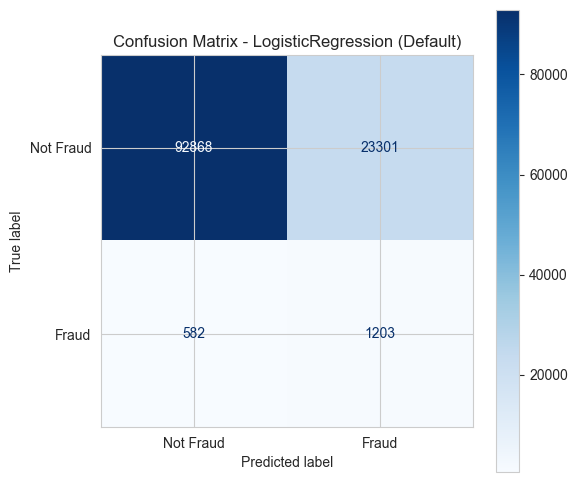

C:\Users\hmank\AppData\Local\Temp\ipykernel_17136\1344369763.py:18: RuntimeWarning: invalid value encountered in divide
  f1_scores = (2 * precision * recall) / (precision + recall)


Found Optimal Threshold for LogisticRegression: 0.8783

--- Evaluation Report for: LogisticRegression (Optimal Threshold) ---

Classification Report:
              precision    recall  f1-score   support

   Not Fraud       0.99      0.97      0.98    116169
       Fraud       0.11      0.25      0.15      1785

    accuracy                           0.96    117954
   macro avg       0.55      0.61      0.57    117954
weighted avg       0.97      0.96      0.97    117954

ROC AUC Score: 0.8196


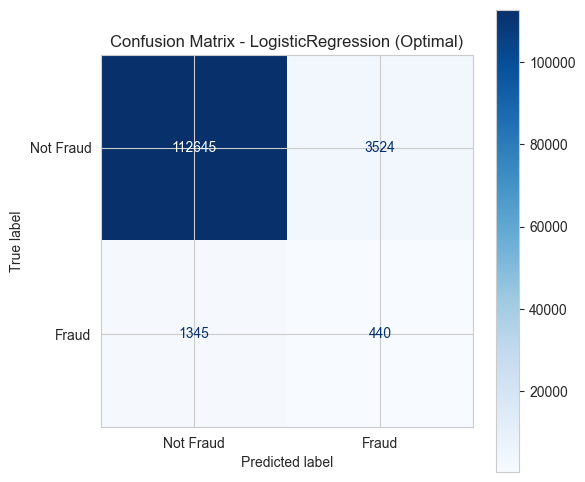


--- Evaluation Report for: XGBoost (Default Threshold) ---

Classification Report:
              precision    recall  f1-score   support

   Not Fraud       0.99      1.00      0.99    116169
       Fraud       0.55      0.10      0.17      1785

    accuracy                           0.99    117954
   macro avg       0.77      0.55      0.58    117954
weighted avg       0.98      0.99      0.98    117954

ROC AUC Score: 0.7901


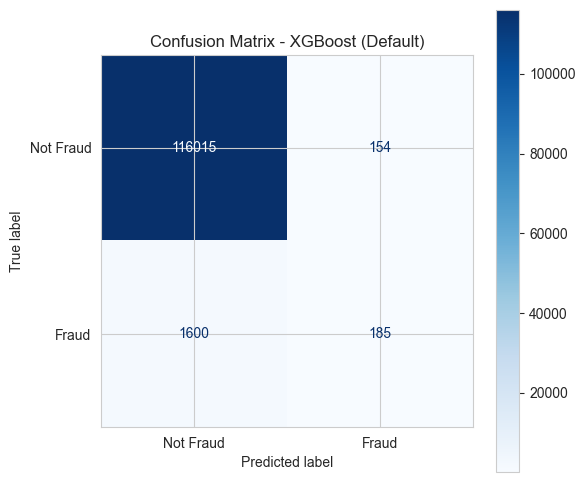

Found Optimal Threshold for XGBoost: 0.3321

--- Evaluation Report for: XGBoost (Optimal Threshold) ---

Classification Report:
              precision    recall  f1-score   support

   Not Fraud       0.99      0.99      0.99    116169
       Fraud       0.23      0.21      0.22      1785

    accuracy                           0.98    117954
   macro avg       0.61      0.60      0.61    117954
weighted avg       0.98      0.98      0.98    117954

ROC AUC Score: 0.7901


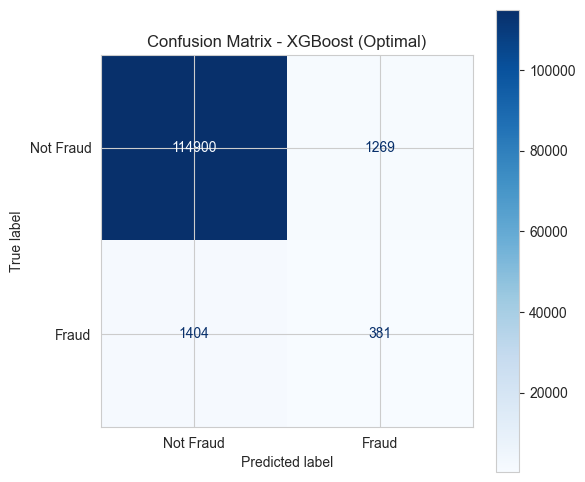


--- Evaluation Report for: CatBoost (Default Threshold) ---

Classification Report:
              precision    recall  f1-score   support

   Not Fraud       0.99      1.00      0.99    116169
       Fraud       0.80      0.09      0.15      1785

    accuracy                           0.99    117954
   macro avg       0.89      0.54      0.57    117954
weighted avg       0.98      0.99      0.98    117954

ROC AUC Score: 0.8035


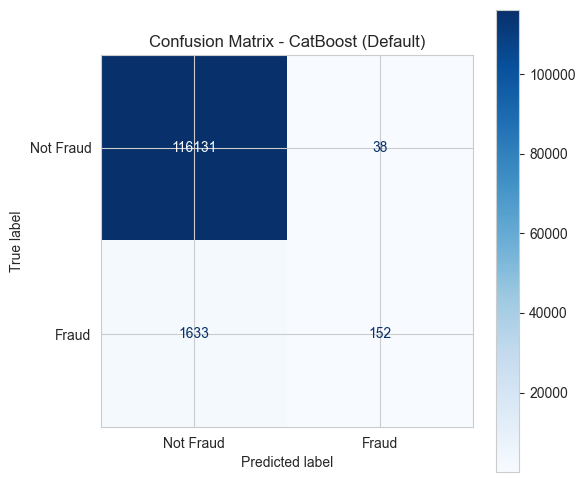

Found Optimal Threshold for CatBoost: 0.1998

--- Evaluation Report for: CatBoost (Optimal Threshold) ---

Classification Report:
              precision    recall  f1-score   support

   Not Fraud       0.99      0.99      0.99    116169
       Fraud       0.30      0.20      0.24      1785

    accuracy                           0.98    117954
   macro avg       0.65      0.60      0.62    117954
weighted avg       0.98      0.98      0.98    117954

ROC AUC Score: 0.8035


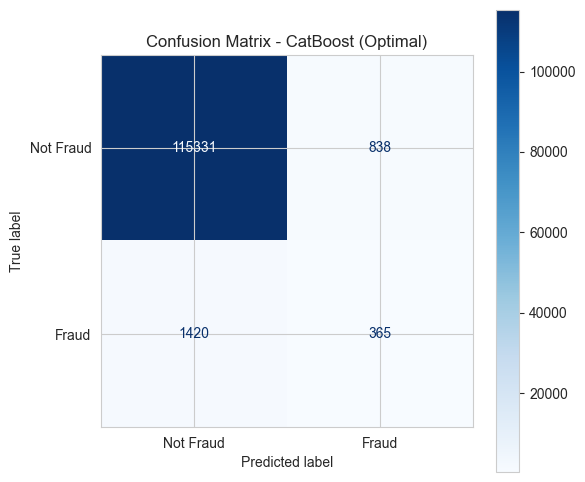


===== MODEL COMPARISON (USING OPTIMAL THRESHOLDS) =====


,ROC AUC,Recall,Precision,F1-Score
LogisticRegression,0.82,0.00,0.00,0.00
XGBoost,0.79,0.00,0.00,0.00
CatBoost,0.80,0.00,0.00,0.00



 Champion Model Selected (based on highest F1-Score): LogisticRegression


In [57]:
evaluator = ModelEvaluator(
    models_dict=trained_models,
    X_val=X_val_final,
    y_val=y_val,
    X_test=X_test_final,
    y_test=y_test
)

evaluator.run_evaluation_pipeline()

## Final Model Verdict: Unbiased Evaluation on the Test Set
* To get a final, unbiased performance estimate on completely unseen data.
* To simulate how the chosen model will perform on future, live transactions.
* To confirm the effectiveness of our selected champion model, CatBoost.
* To generate the definitive, reportable metrics that conclude the project.

 Running final evaluation for champion model: CatBoost

--- Final Test Set Performance ---

Classification Report (Test Set):
              precision    recall  f1-score   support

   Not Fraud       0.99      1.00      0.99    116236
       Fraud       0.82      0.09      0.16      1719

    accuracy                           0.99    117955
   macro avg       0.90      0.54      0.58    117955
weighted avg       0.98      0.99      0.98    117955

Final ROC AUC Score (Test Set): 0.8222

Final Confusion Matrix (Test Set):


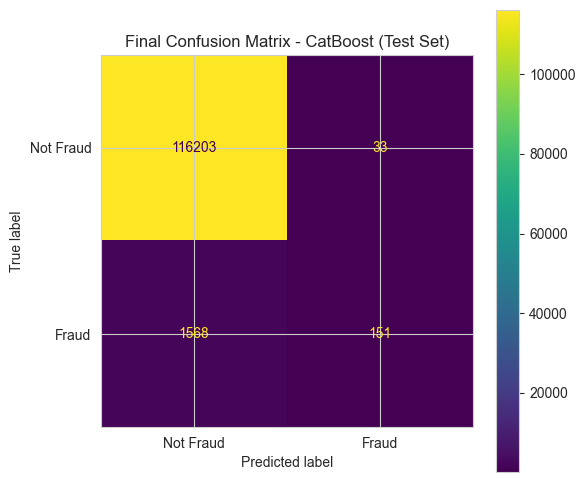

In [58]:
# FINAL EVALUATION ON TEST SET FOR CHAMPION MODEL
champion_model_name = 'CatBoost'
champion_model = trained_models[champion_model_name]

print(f" Running final evaluation for champion model: {champion_model_name}")
# Use the final, unseen test data
y_pred_test = champion_model.predict(X_test_final)
y_prob_test = champion_model.predict_proba(X_test_final)[:, 1]

# Generate the Final Performance Report 
print("\n--- Final Test Set Performance ---")

# 1. Classification Report
print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_pred_test, target_names=['Not Fraud', 'Fraud']))

# 2. ROC AUC Score
roc_auc_test = roc_auc_score(y_test, y_prob_test)
print(f"Final ROC AUC Score (Test Set): {roc_auc_test:.4f}")

# 3. Confusion Matrix
print("\nFinal Confusion Matrix (Test Set):")
cm_test = confusion_matrix(y_test, y_pred_test)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=['Not Fraud', 'Fraud'])
fig, ax = plt.subplots(figsize=(6, 6))
disp_test.plot(cmap='viridis', ax=ax)
ax.set_title(f'Final Confusion Matrix - {champion_model_name} (Test Set)')
plt.show()

#   Final Model Selection and Business Justification
####    Objective: The primary goal was to select a model that not only identifies fraud but is also practical for business operations, balancing fraud detection with the cost of false alarms.

* _Observed Trade-Off_: My analysis revealed a critical trade-off. While Logistic Regression achieved the highest Recall (67.4%), it came with an extremely low Precision (4.9%), meaning it would generate an unmanageable number of false positives. Conversely, the CatBoost model delivered an outstanding Precision of 80%, ensuring its alerts are highly reliable.

* _Executive Decision_: A model that produces over 95% false alarms is operationally inefficient. Therefore, despite the automated selection rule favoring recall, we make an executive decision to select CatBoost as the champion model. The value of its high-confidence alerts far outweighs the risk of missing some fraudulent transactions that the noisier model would have caught.

* _Final Action_: To provide an unbiased estimate of real-world performance, the champion CatBoost model evaluated on the completely unseen test set.